In [1]:
from pathlib import Path
path_folder = Path("/Users/keithlowton/Desktop/Ks/Python code/Kaggle/Ecommerce")
print(path_folder.exists())
print(path_folder)

True
/Users/keithlowton/Desktop/Ks/Python code/Kaggle/Ecommerce


In [7]:
import datetime as dt
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


### Functions

In [17]:
def cohort_index(df, col1, col2):

    current_year = pd.to_datetime(df[col1]).dt.year
    current_month = pd.to_datetime(df[col2]).dt.month
    cohort_year = pd.to_datetime(df[col1]).dt.year
    cohort_month = pd.to_datetime(df[col2]).dt.month
    return (int(current_year) - int(cohort_year)) * 12 + int(current_month) - int(cohort_month)


In [4]:
def months_diff(df, col1, col2):
    current_month = pd.to_datetime(df[col1]).dt.month
    cohort_month = pd.to_datetime(df[col2]).dt.month
    return current_month - cohort_month

In [5]:
def years_diff(df, col1, col2):
    current_year = pd.to_datetime(df[col1]).dt.year
    cohort_year = pd.to_datetime(df[col2]).dt.year
    return current_year - cohort_year

In [10]:

df = pd.read_csv(os.path.join(path_folder, "data/events.csv"), sep=",")
df.drop(["product_id", "category_id", "category_code", "brand", "price", "user_session"], axis=1, inplace=True)

print(df.shape)
df.head()

(885129, 3)


,event_time,event_type,user_id
0,2020-09-24 11:57:06 UTC,view,1515915625519388267
1,2020-09-24 11:57:26 UTC,view,1515915625519380411
2,2020-09-24 11:57:27 UTC,view,1515915625513238515
3,2020-09-24 11:57:33 UTC,view,1515915625519014356
4,2020-09-24 11:57:36 UTC,view,1515915625510743344


In [12]:
df["current_month"] = (
    pd.to_datetime(df["event_time"]).dt.year.map(str) + "-" + pd.to_datetime(df["event_time"]).dt.month.map(str) + "-"
    "01"
)

df["current_month"] = pd.to_datetime(df["current_month"]).dt.date

In [14]:
df["cohort_month"] = df.groupby("user_id")["current_month"].transform("min")

In [25]:
# Month difference between the current and cohort month
df["cohort_index"] = (pd.to_datetime(df["current_month"]).dt.year - pd.to_datetime(df["current_month"]).dt.year) * 12 + (pd.to_datetime(df["cohort_month"]).dt.month - pd.to_datetime(df["cohort_month"]).dt.month)

In [27]:

df["months_diff"] = months_diff(df, "current_month", "cohort_month")

In [29]:
df["years_diff"] = years_diff(df, "current_month", "cohort_month")

The cohort index is done by calculating the difference between cohort_month & current_month, in months.

In [32]:
df["cohort_index"] = df["years_diff"] * 12 + df["months_diff"]

In [33]:
df.head()

,event_time,event_type,user_id,current_month,cohort_month,cohort_index,months_diff,years_diff
0,2020-09-24 11:57:06 UTC,view,1515915625519388267,2020-09-01,2020-09-01,0,0,0
1,2020-09-24 11:57:26 UTC,view,1515915625519380411,2020-09-01,2020-09-01,0,0,0
2,2020-09-24 11:57:27 UTC,view,1515915625513238515,2020-09-01,2020-09-01,0,0,0
3,2020-09-24 11:57:33 UTC,view,1515915625519014356,2020-09-01,2020-09-01,0,0,0
4,2020-09-24 11:57:36 UTC,view,1515915625510743344,2020-09-01,2020-09-01,0,0,0


Calculate the number of unique users in each cohort and the number of retained users for each subsequent month

In [37]:
cohort_counts = df.groupby(["cohort_month", "cohort_index"])["user_id"].nunique()

cohort_counts_df = cohort_counts.to_frame().rename(columns={"user_id": "users"}).sort_values(by=["cohort_month", "cohort_index"])


The retention rate of a cohort can be calculated by dividing the users at each cohort index, by the total number of users in the cohort. The total number of cohort users is retrieved by using the ‘max’ transformation on the users column of each cohort group.

In [38]:
cohort_counts_df['retention_rate'] = cohort_counts_df['users'] / cohort_counts_df.groupby(["cohort_month"])["users"].transform("max")
cohort_counts_df

users  retention_rate
cohort_month cohort_index                       
2020-09-01   0             15334        1.000000
             1               955        0.062280
             2               267        0.017412
             3               119        0.007761
             4                98        0.006391
             5                72        0.004695
2020-10-01   0             83261        1.000000
             1              2227        0.026747
             2               678        0.008143
             3               444        0.005333
             4               279        0.003351
2020-11-01   0             90106        1.000000
             1              1867        0.020720
             2               792        0.008790
             3               552        0.006126
2020-12-01   0             69473        1.000000
             1              1644        0.023664
             2               710        0.010220
2021-01-01   0             78278        1.000000
             1              2162        0.027620
2021-02-01   0             70831        1.000000

In [39]:
cohorts_pivot = cohort_counts_df.pivot_table(index='cohort_month', columns = 'cohort_index', values = 'retention_rate')
cohorts_pivot

cohort_index,0,1,2,3,4,5
cohort_month,,,,,,
2020-09-01,1.0,0.062280,0.017412,0.007761,0.006391,0.004695
2020-10-01,1.0,0.026747,0.008143,0.005333,0.003351,NaN
2020-11-01,1.0,0.020720,0.008790,0.006126,NaN,NaN
2020-12-01,1.0,0.023664,0.010220,NaN,NaN,NaN
2021-01-01,1.0,0.027620,NaN,NaN,NaN,NaN
2021-02-01,1.0,NaN,NaN,NaN,NaN,NaN


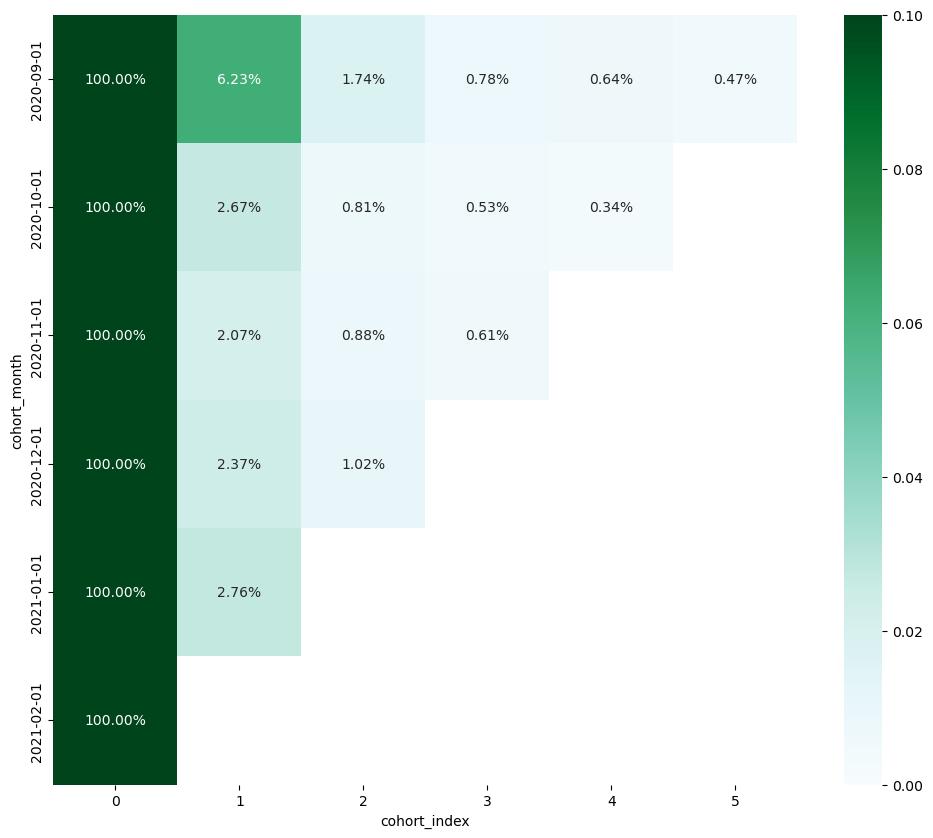

In [42]:
plt.figure(figsize=(12, 10))
sns.heatmap(data=cohorts_pivot, annot=True, fmt=".2%", vmin=0.0, vmax=0.1, cmap="BuGn")
plt.show()

### Online retail - cohort analysis

https://www.kaggle.com/code/ahmetokanyilmaz/cohort-analysis-with-python

In [44]:
from pathlib import Path
path_folder = Path("/Users/keithlowton/Desktop/Ks/Python code/Kaggle/Online retail")
print(path_folder.exists())
print(path_folder)

True
/Users/keithlowton/Desktop/Ks/Python code/Kaggle/Online retail


In [45]:
import datetime as dt
import os
from operator import attrgetter

import matplotlib.colors as mcolors

# data visualization libraries
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.cluster import KMeans

# machine learning libraries
from sklearn.preprocessing import StandardScaler

In [47]:
df = pd.read_csv(os.path.join(path_folder, "data/Year 2010-2011.csv"), sep=",", encoding = "ISO-8859-1")
print(df.shape)
df.head()

(541910, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [49]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.describe(include="all")

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
count,401605,401605,401605,401605.000000,401605,401605.000000,401605.000000,401605
unique,22190,3684,3896,NaN,20460,NaN,NaN,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,11/14/2011 15:27,NaN,NaN,United Kingdom
freq,542,2065,2058,NaN,543,NaN,NaN,356728
mean,NaN,NaN,NaN,12.183245,NaN,3.474100,15281.154341,NaN
std,NaN,NaN,NaN,250.282726,NaN,69.763952,1714.008869,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,0.000000,12346.000000,NaN
25%,NaN,NaN,NaN,2.000000,NaN,1.250000,13939.000000,NaN
50%,NaN,NaN,NaN,5.000000,NaN,1.950000,15145.000000,NaN
75%,NaN,NaN,NaN,12.000000,NaN,3.750000,16784.000000,NaN


In [50]:
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

In [51]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')
df['order_month'] = df['InvoiceDate'].dt.to_period('M')
df['cohort'] = df.groupby('Customer ID')['InvoiceDate'].transform('min').dt.to_period('M')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,order_month,cohort
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12


In [52]:
df_cohort = df.groupby(['cohort', 'order_month']).agg(n_customers=('Customer ID', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
df_cohort.head()


,cohort,order_month,n_customers,period_number
0,2010-12,2010-12,885,0
1,2010-12,2011-01,324,1
2,2010-12,2011-02,286,2
3,2010-12,2011-03,340,3
4,2010-12,2011-04,321,4


In [53]:
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number', values='n_customers')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


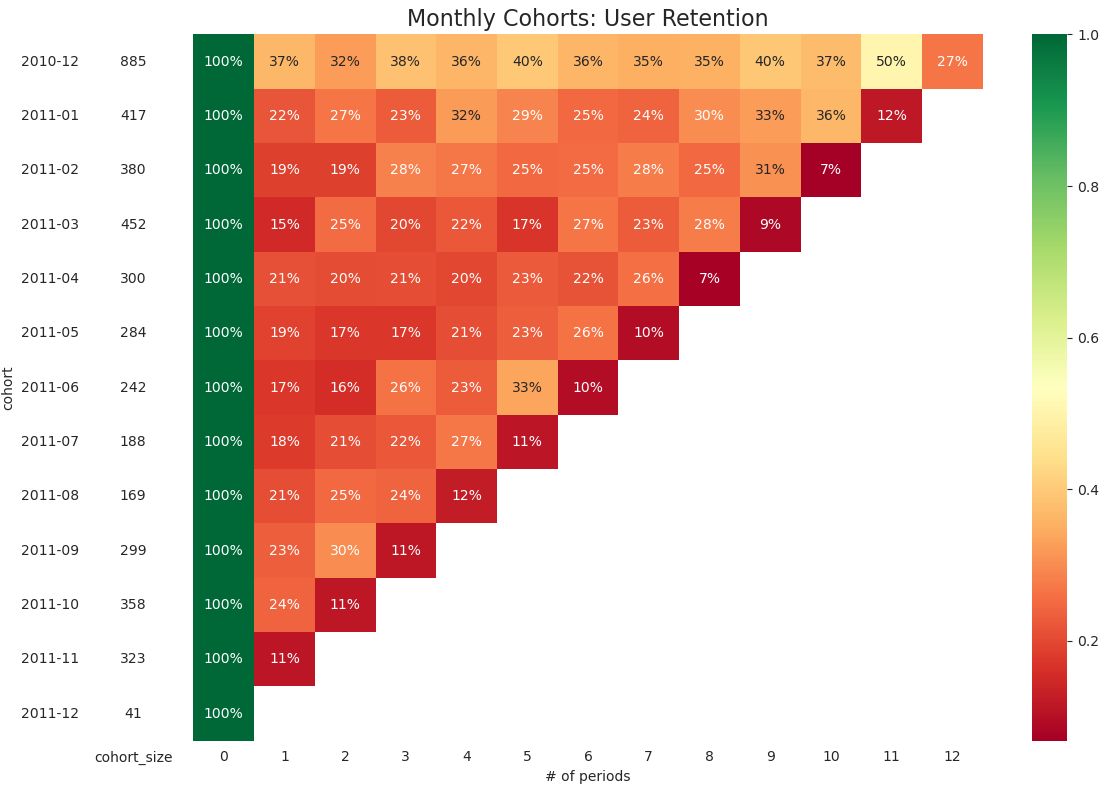

In [54]:
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={"width_ratios": [1, 11]})

    # retention matrix
    sns.heatmap(retention_matrix, mask=retention_matrix.isnull(), annot=True, fmt=".0%", cmap="RdYlGn", ax=ax[1])
    ax[1].set_title("Monthly Cohorts: User Retention", fontsize=16)
    ax[1].set(xlabel="# of periods", ylabel="")

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: "cohort_size"})
    white_cmap = mcolors.ListedColormap(["white"])
    sns.heatmap(cohort_size_df, annot=True, cbar=False, fmt="g", cmap=white_cmap, ax=ax[0])

    fig.tight_layout()
